## __Vector Quantized Variational AutoEncoder (VQ-VAE)__ Modelling

Source: [Neural Discrete Representation Learning](https://proceedings.neurips.cc/paper/2017/hash/7a98af17e63a0ac09ce2e96d03992fbc-Abstract.html)

- This modelling of VQ-VAE with ``celebA`` dataset is done on Google Colab with T4 GPU

In [1]:
!pip install -q kaggle
!pip install -q torchinfo

In [2]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision.transforms import v2
from torchinfo import summary

In [4]:
import os
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()

In [5]:
data_dir = 'celeba'

#Checking if the dataset is already downloaded
downloaded_flag = os.path.join(data_dir, 'img_align_celeba')

if not os.path.exists(downloaded_flag):
    os.makedirs(data_dir, exist_ok=True)
    api.dataset_download_files('jessicali9530/celeba-dataset', path=data_dir, unzip=True)
    print("Download and Extraction complete.")
else:
    print("Dataset already downloaded. Skipping download.")

Dataset URL: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset
Download and Extraction complete.


In [6]:
transform = v2.Compose([v2.ToImage(),
                        v2.ToDtype(torch.float32, scale=True),
                        v2.Resize((64, 64)),
                        #clipping values in between 0 and 1
                        v2.Lambda(lambda x: x.clamp(0, 1)),
])

#Loading CelebA dataset for training
celeba_data = datasets.ImageFolder(root='celeba/img_align_celeba', transform=transform)

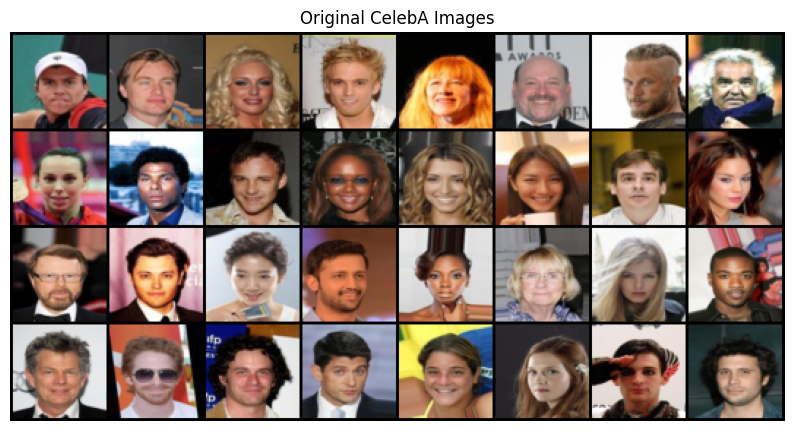

In [7]:
#Creating data loaders for training
batch_size = 128
celeba_loader = DataLoader(celeba_data, batch_size=batch_size, shuffle=True)

def show_images(images, title=None, nrow=8):
    grid = make_grid(images, nrow=nrow, padding=2)
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(grid, (1,2,0))) # changing order of grid to (H, W, C)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

# Getting new batch of training celeba data
dataiter = iter(celeba_loader)
images, _ = next(dataiter)

# Plotting images
show_images(images[:32], "Original CelebA Images")

### __VQ-VAE Architecture__

VQ_VAE uses __discrete latent variable__ instead of continuous to pass into decoder of the network.

At first, we define a latent embedding space $e\in \mathbb{R}^{k\times D}$ where $K$ is the size of discrete latent space and $D$ is the dimension of each latent embedding vector.

- Model takes the input $x$ and encoder output $z_{e}(x)$
- __Discrete latent variable (z)__ are then calculated by nearest neighbour look up from the shared embedding space, $e$ as given below:

$$
q(z=k \mid x) =
\begin{cases}
1 & \text{if } k = \arg\min_j \| z_e(x) - e_j \|_2 \\
0 & \text{otherwise}
\end{cases}$$

- The encoder output of $z_{e}(x)$ is replaced by nearest embedding vector $e_{k}$
- This makes posterior $q(z |x)$ a one-hot categorical distribution, and these embedding are then used as an input in decoder network.

This is the __Vector Quantization__ process and quantized version of decoder input of $z_{e}(x)$ - $z_{q}(x)$ is given by:

$$ z_{q}(x) = e_{k} \quad \text{where} \quad
k = \arg\min_j \| z_e(x) - e_j \|_2 $$



### __Training Part__

During the forward pass, the nearest embedding $z_{q}(x)$ is passed to the decoder, and during the backwards pass the gradient $∇_{z}L$ is passed unaltered to the encoder.

In [8]:
class VectorQuantizer(nn.Module):

    def __init__(self, num_embeddings, embedding_dim, commitment_cost=0.2):
        super().__init__()
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim
        self.commitment_cost = commitment_cost

        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.embedding.weight.data.uniform_(-1/num_embeddings, 1/num_embeddings)

    def forward(self, x):
        # x shape: (B, C, H, W) → reshape to (B*H*W, C)
        flat_x = x.permute(0, 2, 3, 1).contiguous()
        flat_x = flat_x.view(-1, self.embedding_dim)

        # Compute distances
        distances = (
            torch.sum(flat_x**2, dim=1, keepdim=True) +
            torch.sum(self.embedding.weight**2, dim=1) -
            2 * torch.matmul(flat_x, self.embedding.weight.t()))

        encoding_indices = torch.argmin(distances, dim=1)
        quantized = self.embedding(encoding_indices)

        # Reshape back
        quantized = quantized.view(x.shape[0], x.shape[2], x.shape[3], -1).permute(0, 3, 1, 2)

        # Straight-Through Estimator
        quantized = x + (quantized - x).detach()

        # Losses
        codebook_loss = F.mse_loss(quantized.detach(), x)
        commitment_loss = F.mse_loss(x.detach(), quantized)
        vq_loss = codebook_loss + self.commitment_cost * commitment_loss

        # Return quantized, vq_loss, and encoding_indices
        return quantized, vq_loss, encoding_indices.view(x.shape[0], -1)

In [9]:
class VQVAE(nn.Module):
    def __init__(self, num_embeddings=128, embedding_dim=32, commitment_cost=0.2):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(128, embedding_dim, 1)
        )

        self.vq = VectorQuantizer(num_embeddings, embedding_dim, commitment_cost)

        self.decoder = nn.Sequential(

            nn.ConvTranspose2d(embedding_dim, 128, 4, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(64, 3, 3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        quantized, vq_loss, encoding_indices = self.vq(z)
        x_recon = self.decoder(quantized)
        return x_recon, vq_loss, encoding_indices

    def decode_from_indices(self, indices):
        # Convert indices to quantized vectors
        quantized = self.vq.embedding(indices)
        # Reshape to (B, H, W, C) then permute to (B, C, H, W)
        quantized = quantized.view(indices.shape[0], 8, 8, -1).permute(0, 3, 1, 2)
        return self.decoder(quantized)


In [10]:
num_epochs = 10
learning_rate = 25e-4

model = VQVAE(num_embeddings=64, embedding_dim=16)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#for GPU training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Using device: {device}")

Using device: cuda


In [11]:
print(summary(model, input_size=(128,3, 64, 64)))

Layer (type:depth-idx)                   Output Shape              Param #
VQVAE                                    [128, 3, 64, 64]          --
├─Sequential: 1-1                        [128, 16, 16, 16]         --
│    └─Conv2d: 2-1                       [128, 64, 32, 32]         3,136
│    └─LeakyReLU: 2-2                    [128, 64, 32, 32]         --
│    └─Conv2d: 2-3                       [128, 128, 16, 16]        131,200
│    └─LeakyReLU: 2-4                    [128, 128, 16, 16]        --
│    └─Conv2d: 2-5                       [128, 16, 16, 16]         2,064
├─VectorQuantizer: 1-2                   [128, 16, 16, 16]         --
│    └─Embedding: 2-6                    [32768, 16]               1,024
├─Sequential: 1-3                        [128, 3, 64, 64]          --
│    └─ConvTranspose2d: 2-7              [128, 128, 32, 32]        32,896
│    └─LeakyReLU: 2-8                    [128, 128, 32, 32]        --
│    └─ConvTranspose2d: 2-9              [128, 64, 64, 64]         

In [12]:
#training loop
import time
from tqdm import tqdm
start = time.perf_counter()
def train(epoch):

  model.train()
  accumulated_recon_loss = 0
  accumulated_codebook_loss = 0
  accumulated_commitment_loss = 0
  accumulated_vq_loss = 0
  training_loss = 0

  for batch_idx, (data, _) in enumerate(tqdm(celeba_loader)):
    data = data.to(device)

    optimizer.zero_grad()
    recon_batch, vq_loss, _ = model(data)

    recon_loss = F.binary_cross_entropy(recon_batch, data, reduction='mean')
    total_loss = recon_loss + vq_loss

    total_loss.backward()
    training_loss += total_loss.item()
    accumulated_recon_loss += recon_loss.item()
    accumulated_vq_loss += vq_loss.item()
    optimizer.step()

  print(f'Epoch: {epoch} Total Loss: {training_loss / len(celeba_loader.dataset):.4f} '
          f'Reconstruction Loss: {accumulated_recon_loss / len(celeba_loader.dataset):.4f} '
          f'VQ Loss: {accumulated_vq_loss / len(celeba_loader.dataset):.4f}')

for epoch in range(1, num_epochs + 1):
  train(epoch)

end = time.perf_counter()
s2mps = lambda s: f"{s // 60:.0f} min {s % 60:.2f} s"
print(f"Total Training Time: {s2mps(end - start)}")

100%|██████████| 1583/1583 [07:15<00:00,  3.63it/s]


Epoch: 1 Total Loss: 0.1268 Reconstruction Loss: 0.0040 VQ Loss: 0.1227


100%|██████████| 1583/1583 [07:08<00:00,  3.70it/s]


Epoch: 2 Total Loss: 0.0597 Reconstruction Loss: 0.0039 VQ Loss: 0.0558


100%|██████████| 1583/1583 [07:10<00:00,  3.68it/s]


Epoch: 3 Total Loss: 0.0584 Reconstruction Loss: 0.0039 VQ Loss: 0.0545


100%|██████████| 1583/1583 [07:07<00:00,  3.71it/s]


Epoch: 4 Total Loss: 0.0600 Reconstruction Loss: 0.0039 VQ Loss: 0.0561


100%|██████████| 1583/1583 [07:08<00:00,  3.69it/s]


Epoch: 5 Total Loss: 0.0721 Reconstruction Loss: 0.0039 VQ Loss: 0.0682


100%|██████████| 1583/1583 [07:10<00:00,  3.68it/s]


Epoch: 6 Total Loss: 0.0740 Reconstruction Loss: 0.0039 VQ Loss: 0.0702


100%|██████████| 1583/1583 [07:08<00:00,  3.70it/s]


Epoch: 7 Total Loss: 0.0661 Reconstruction Loss: 0.0039 VQ Loss: 0.0623


100%|██████████| 1583/1583 [07:08<00:00,  3.69it/s]


Epoch: 8 Total Loss: 0.0669 Reconstruction Loss: 0.0039 VQ Loss: 0.0631


100%|██████████| 1583/1583 [07:02<00:00,  3.74it/s]


Epoch: 9 Total Loss: 0.0698 Reconstruction Loss: 0.0039 VQ Loss: 0.0659


100%|██████████| 1583/1583 [07:03<00:00,  3.74it/s]

Epoch: 10 Total Loss: 0.0751 Reconstruction Loss: 0.0039 VQ Loss: 0.0713
Total Training Time: 71 min 23.15 s


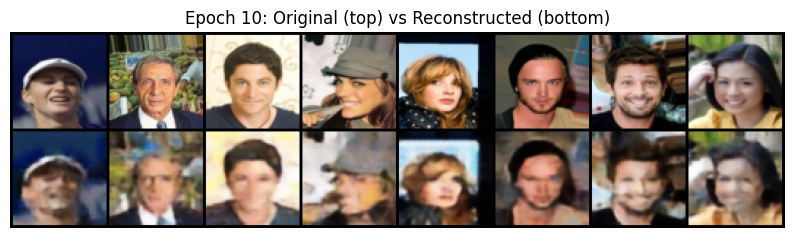

In [17]:
# reconstructing some images after last epoch
model.eval()
torch.manual_seed(40)
with torch.no_grad():

  sample = images[:8].to(device)
  recon, _, _ = model(sample)

  comparison = torch.cat([sample.cpu(), recon.cpu()])
  show_images(comparison, f'Epoch {epoch}: Original (top) vs Reconstructed (bottom)')

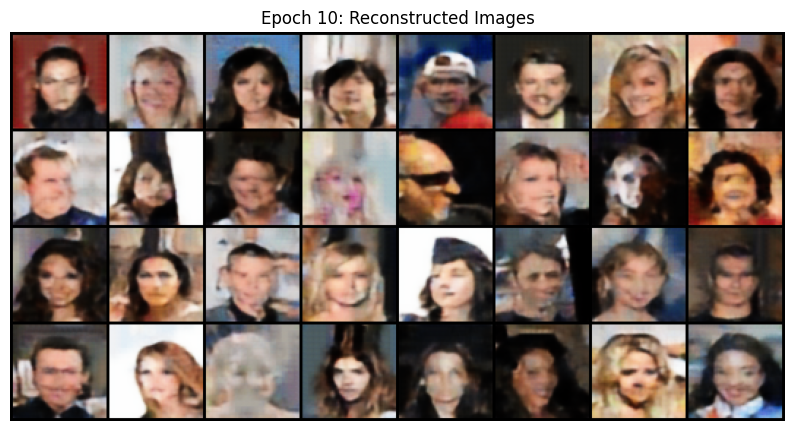

In [18]:
# displaying only reconstructed images
model.eval()
with torch.no_grad():
  dataiter = iter(celeba_loader)
  images, _ = next(dataiter)

  sample = images[:32].to(device)
  recon, _, _ = model(sample)

  show_images(recon.cpu(), f'Epoch {epoch}: Reconstructed Images')